# Chapter 7 回帰分析の悩みどころ

## 7.1 交互作用

交互作用とは、回帰分析において説明変数同士の掛け算などの項を考慮すること。

例えば5.1節のモデルに説明変数の交互作用の項を追加すると、
$$
\begin{align}
&\mu[n] = b_1 + b_2 A[n] + b_3 Score[n] &n = 1, \ldots, N \nonumber \\
&\mathrm{に交互作用の項を追加} \nonumber \\
&\mu[n] = b_1 + b_2 A[n] + b_3 Score[n] + b_4A[n]Score[n] &n = 1, \ldots, N \nonumber \\
&\mathrm{式変形すると} \nonumber \\
&\mu[n] = b_1 + b_2 A[n] + (b_3 + b_4A[n]) Score[n] &n = 1, \ldots, N \nonumber \\
\end{align}
$$
となる。アルバイトが好きかどうか$A[n]$によって、$Score$が増えた時の傾きが変わることになる。この交互作用の解釈は一般的にはかなり複雑になるため、重回帰では交互作用を考慮しない倍が多い。(前もって交互作用を確認できている場合、交互作用を知ることが目的の場合を除く)

また、説明変数$A[n]$のかわりに4つのクラブへの所属状況$c_j[n] \ j=1, \ldots, 4$を考える場合。交互作用の項は以下になる。
$$
(b_3 + b_4 C_1[n] + b_5 C_2[n] + b_6 C_3[n] + b_7 C_4[n])Score[n]
$$
このとき、サンプル数の少ないクラブに掛かっている係数$b$は推定に失敗する。そこで$b_4 \sim b_7$は類似しているというゆるい制約を入れる方法がある。8章の階層モデルで説明。

## 7.2 対数を取るか否か

対数によって変数変換すると解釈がしやすいケースがある。例えば変数の対数を取ってから回帰を行うなど手法が当てはめられる。

対数を取ると、説明変数と応答変数の関係が何倍という物差しで解釈できる。

以下に関東近辺の架空の賃貸物件のデータ(data-rental.txt)について、横軸に部屋の広さ、縦軸に2年間のトータル費用をとって散布図にしたものを示す。左は非対数、右は両対数グラフ。

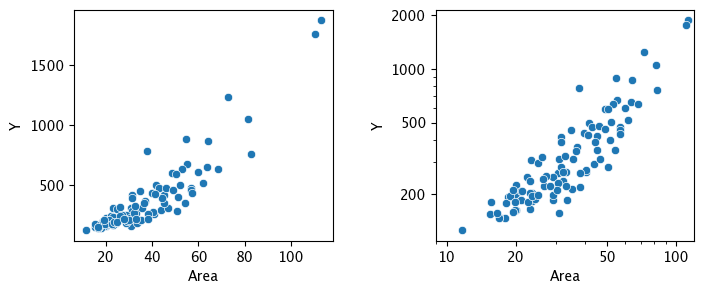

In [1]:
import numpy as np
import polars as pl
import seaborn as sns
from matplotlib import pyplot as plt

"""散布図."""
rental = pl.read_csv("chap07/input/data-rental.txt")

_, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3))
plt.subplots_adjust(wspace=0.4, hspace=0.6)
sns.scatterplot(rental, x="Area", y="Y", ax=ax1)
plt.setp(ax1, xticks=np.arange(20, 120, 20), yticks=np.arange(500, 2000, 500))
sns.scatterplot(rental, x="Area", y="Y", ax=ax2)
xticks = (1, 2, 5, 10, 20, 50, 100)
yticks = (200, 500, 1000, 2000)
plt.setp(
    ax2,
    xscale="log",
    yscale="log",
    xticks=xticks,
    xticklabels=xticks,
    yticks=yticks,
    yticklabels=yticks,
    xlim=(9, 120),
)
plt.show()

下記の二通りのモデルで単回帰してみる。

- Nは物件数
- nは物件のインデックス

モデル式 7-1 ([model7-1.stan](chap07/model/model7-1.stan))
$$
\begin{align}
&\mu[n] = b_1 + b_2 Area[n] &n=1, \ldots, N \nonumber \\
&Y[n] \sim \mathrm{Normal }(\mu[n], \sigma_Y) &n=1, \ldots, N \nonumber
\end{align}
$$

非対数のグラフに直線を当てはめて、正規分布に従うノイズを仮定したモデル。

モデル式 7-2 ([model7-2.stan](chap07/model/model7-2.stan))
$$
\begin{align}
&\mu[n] = b_1 + b_2 \log_{10} (Area[n]) &n=1, \ldots, N \nonumber \\
&log_{10}(Y[n]) \sim \mathrm{Normal }(\mu[n], \sigma_Y) &n=1, \ldots, N \nonumber
\end{align}
$$

両対数のグラフに直線を当てはめて正規分布に従うノイズを仮定したモデル。

両モデルをStanで実装し、推定を行い、次に、
- 予測分布
- 実測値と予測値のプロット
- 推定されたノイズの分布

を確認する

In [2]:
import numpy as np
import polars as pl
from cmdstanpy import CmdStanModel

"""推定"""
rental = pl.read_csv("chap07/input/data-rental.txt")

N_new = 50
Area_new = np.linspace(10, 120, N_new)
data1 = {
    "N": rental.shape[0],
    "Area": rental["Area"].to_list(),
    "Y": rental["Y"].to_list(),
    "N_new": N_new,
    "Area_new": Area_new,
}
sm1 = CmdStanModel(
    stan_file="chap07/model/model7-1.stan",
    cpp_options={"STAN_THREADS": "TRUE"},
)
fit1 = sm1.sample(data=data1, seed=1234)

data2 = {
    "N": rental.shape[0],
    "Area": rental["Area"].log10().to_list(),
    "Y": rental["Y"].log10().to_list(),
    "N_new": N_new,
    "Area_new": np.log10(Area_new),
}
sm2 = CmdStanModel(
    stan_file="chap07/model/model7-2.stan",
    cpp_options={"STAN_THREADS": "TRUE"},
)
fit2 = sm2.sample(data=data2, seed=1234)

07:05:29 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

07:05:30 - cmdstanpy - INFO - CmdStan done processing.


07:05:30 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

07:05:31 - cmdstanpy - INFO - CmdStan done processing.
07:05:31 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/sean/Documents/myscript/python-bayes/src/python_bayes/chap07/model/model7-2.stan', line 23, column 4 to column 30)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/sean/Documents/myscript/python-bayes/src/python_bayes/chap07/model/model7-2.stan', line 23, column 4 to column 30)
Consider re-running with show_console=True if the above output is unclear!


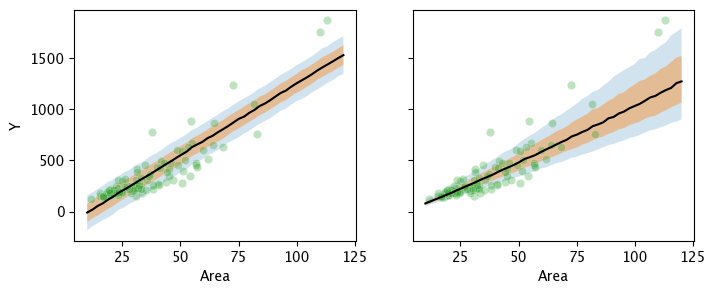

In [53]:
import seaborn as sns
from matplotlib import pyplot as plt

"""予測分布"""
def calc_quantiles(y_pred: np.ndarray, prob: list[int]) -> pl.DataFrame:
    """入力された数値のリストから分位数を計算."""
    return pl.DataFrame(
        np.percentile(y_pred, prob, axis=0).T,
        schema=[f"p{p}" for p in prob],
    )


ms1 = {
    "y_pred": fit1.y_pred,
    "y_new": fit1.y_new,
}

ms2 = {
    "y_pred": np.power(10, fit2.y_pred),
    "y_new": np.power(10, fit2.y_new),
}
_, axes = plt.subplots(1, 2, figsize=(8, 3), sharex=True, sharey=True)
for ms, ax in zip([ms1, ms2], axes, strict=True):
    d_est = calc_quantiles(ms["y_new"], [10, 25, 50, 75, 90])
    ax.fill_between(Area_new, d_est["p10"], d_est["p90"], alpha=0.2)
    ax.fill_between(Area_new, d_est["p25"], d_est["p75"], alpha=0.4)
    ax.plot(Area_new, d_est["p50"], color="k")
    sns.scatterplot(rental, x="Area", y="Y", ax=ax, alpha=0.3)
plt.show()

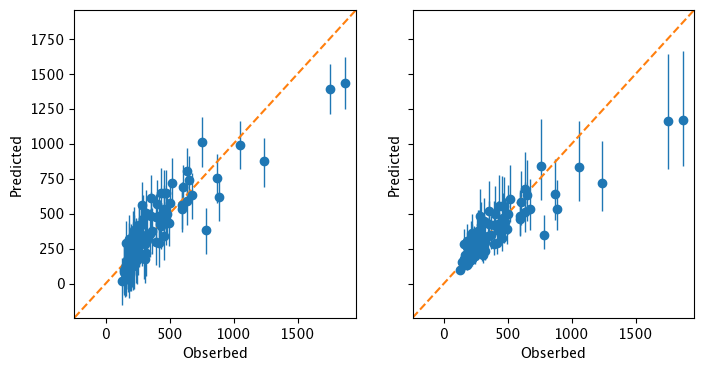

In [4]:
"""実測値と予測値のプロット"""
from matplotlib import pyplot as plt

_, axes = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)
for ms, ax in zip([ms1, ms2], axes, strict=True):
    d_est = calc_quantiles(ms["y_pred"], [10, 50, 90])
    ax.errorbar(
        rental["Y"],
        d_est["p50"],
        yerr=[d_est["p50"] - d_est["p10"], d_est["p90"] - d_est["p50"]],
        fmt="o",
        elinewidth=1,
    )
    xmin, xmax = ax.get_xlim()
    ymin, ymax = ax.get_ylim()
    lim = (min(xmin, ymin), max(xmax, ymax))
    ax.plot(lim, lim, linestyle="dashed")
    plt.setp(ax, xlim=lim, ylim=lim, xlabel="Obserbed", ylabel="Predicted")
plt.show()

06:01:55 - cmdstanpy - INFO - Chain [1] start processing


06:01:55 - cmdstanpy - INFO - Chain [1] done processing
06:01:55 - cmdstanpy - INFO - Chain [1] start processing
06:01:55 - cmdstanpy - INFO - Chain [1] done processing
06:01:55 - cmdstanpy - WARNING - The default behavior of CmdStanMLE.stan_variable() will change in a future release to always return a numpy.ndarray, even for scalar variables.
06:01:55 - cmdstanpy - WARNING - The default behavior of CmdStanMLE.stan_variable() will change in a future release to always return a numpy.ndarray, even for scalar variables.


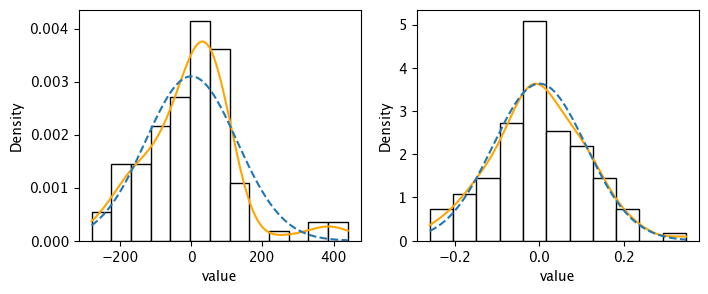

In [5]:
import seaborn as sns
from matplotlib import pyplot as plt
from scipy import stats

"""推定されたノイズの分布"""
def calc_MCMC_noise(Y: pl.Series, mu: np.ndarray) -> pl.DataFrame:  # noqa: N803, N802
    """ノイズを計算."""
    return pl.DataFrame(Y.to_numpy() - mu, schema=["noise"])


N_mcmc1 = fit1.method_variables()["lp__"].size
N_mcmc2 = fit2.method_variables()["lp__"].size


MAP_data1 = sm1.optimize(data=data1, jacobian=True, seed=1234)
MAP_data2 = sm2.optimize(data=data2, jacobian=True, seed=1234)

N_mcmc1 = fit1.method_variables()["lp__"].size
N_mcmc2 = fit2.method_variables()["lp__"].size
d_noise_MAP1 = calc_MCMC_noise(rental["Y"], MAP_data1.mu)  # noqa: N816
d_noise_MAP2 = calc_MCMC_noise(rental["Y"].log10(), MAP_data2.mu)  # noqa: N816


_, axes = plt.subplots(1, 2, figsize=(8, 3))
for d_noise_MAP, s_Y, ax in zip(  # noqa: N816
    [d_noise_MAP1, d_noise_MAP2],
    [MAP_data1.s_Y, MAP_data2.s_Y],
    axes,
    strict=True,
):
    sns.histplot(
        d_noise_MAP["noise"],
        ax=ax,
        kde=True,
        stat="density",
        color="orange",
        facecolor="w",
    )
    xdata = ax.lines[0].get_xdata()
    ax.plot(xdata, stats.norm.pdf(xdata, scale=s_Y), linestyle="dashed")
    plt.setp(ax, xlabel="value")

plt.show()

これらの図から非対数の数値の場合は、
- 80%ベイズ予測区間が負の値を合む(予測分布。実測値-予測値のプロット)
- 広くて費用が高い物件(Areaがおよそ70m$^2$以上の物件)に結果が引きずられてノイズの分布が歪んでおり、正規分布と乖離がある(推定されたノイズの分布のプロット)
  
  この原因は、家賃が高いほどばらつきが大きくなり、非対数のモデルではそれがそのまま反映されるからである。Areaが100m$^2$より大きい数個の点を除くだけで推定結果が大きく変わってしまうだろう。この状況は頑健性が低いと言えるのでなるべく避けたい。

対数をとって、回帰を行うことでこれらの問題が改善されているが、実測値-予測値のプロットではAreaが大きいほど80%信頼区間も広くなっている。このように非対数と対数のどちらが正しいとは言えず、あくまで今回はそういう仮定をしたにすぎない。

他に指数関数で増えるような現象のメカニズムが背景にあると考えられる場合は対数を取る。複利・細胞分裂など。

## 7.3 非線形の関係

データによっては非線形な曲線を当てはめて回帰を行いたい場合がある。

- 二次曲線の例
  
  ある家庭における夏から冬にかけての一日あたりのエアコン消費電力$Y(kWh)$と、屋外での平均気温$X(℃)$ (data-aircon.txt)

このデータの散布図を見てみれば曲線で回帰できる事がわかるが、ここにどのような曲線を当てはめるべきか。本来はメカニズムから考えるが、それが不明な場合もある。その場合はなるべくシンプルで解釈し易い曲線を当てはめるのがよい。つまりここでは二次曲線となる。モデルとしては、この家庭が「快適と感じる温度$x_0$」に対して、消費電力$Y$は$(X - x_0)^2$に従って増えると仮定する。

モデル式 7-3 ([model7-3.stan](chap07/model/model7-3.stan))

$$
Y[n] \sim \mathrm{Normal }\left(a + b (X[n] - x_0)^2, \sigma_Y \right) \qquad n = 1, \ldots, N
$$

散布図と回帰曲線のプロットを以下で行う

In [6]:
import numpy as np
import polars as pl
from cmdstanpy import CmdStanModel

"""推定"""
aircon = pl.read_csv("chap07/input/data-aircon.txt")

N_new = 60
X_new = np.linspace(-3, 32, N_new)
data = {
    "N": aircon.shape[0],
    "X": aircon["X"].to_list(),
    "Y": aircon["Y"].to_list(),
    "N_new": N_new,
    "X_new": X_new,
}
sm = CmdStanModel(
    stan_file="chap07/model/model7-3.stan",
    cpp_options={"STAN_THREADS": "TRUE"},
)
fit = sm.sample(data=data, seed=1234)
fit.summary()

06:01:55 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

06:01:56 - cmdstanpy - INFO - CmdStan done processing.


,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
lp__,-401.798000,0.033641,1.388530,-404.535000,-401.494000,-400.148000,1703.65,1464.87,1.001940
a,14.196200,0.013747,0.603876,13.200400,14.203900,15.195100,1929.70,1659.25,0.999500
b,0.214209,0.000146,0.005654,0.204915,0.213998,0.223555,1504.69,1293.80,1.000760
x0,18.282300,0.003627,0.153999,18.028100,18.284300,18.539700,1802.51,1549.88,1.000180
s_Y,5.743110,0.005604,0.310096,5.259220,5.728210,6.281280,3062.24,2633.05,0.999682
...,...,...,...,...,...,...,...,...,...
y_new[56],41.733900,0.096758,5.827560,32.155400,41.720300,51.308400,3627.46,3119.06,1.000970
y_new[57],44.683000,0.094563,6.017840,34.370700,44.720700,54.475000,4049.89,3482.28,1.000300
y_new[58],47.775700,0.093411,5.872330,38.441700,47.750100,57.480700,3952.09,3398.18,0.999662
y_new[59],51.091500,0.102511,6.077600,40.910000,51.119900,61.129600,3514.99,3022.34,1.000260


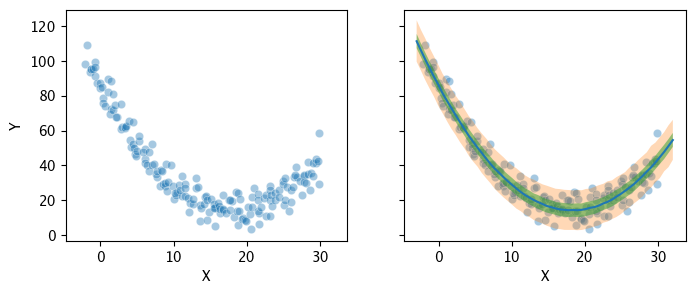

In [7]:
import seaborn as sns
from matplotlib import pyplot as plt

"""図7.5"""
def calc_quantiles(y_pred: np.ndarray, prob: list[int | float]) -> pl.DataFrame:
    """入力された数値のリストから分位数を計算."""
    return pl.DataFrame(
        np.percentile(y_pred, prob, axis=0).T,
        schema=[f"p{p}" for p in prob],
    )


_, axes = plt.subplots(1, 2, figsize=(8, 3), sharex=True, sharey=True)
for ax in axes:
    sns.scatterplot(aircon, x="X", y="Y", ax=ax, alpha=0.4)
d_est = calc_quantiles(fit.y_new, [2.5, 25, 50, 75, 97.5])
axes[-1].fill_between(X_new, d_est["p2.5"], d_est["p97.5"], alpha=0.3)
axes[-1].fill_between(X_new, d_est["p25"], d_est["p75"], alpha=0.5)
axes[-1].plot(X_new, d_est["p50"])
plt.show()

- 時系列データの例
  
  患者に点滴を投与する。投与からの経過時間$Time(hour)$と薬の血中濃度$Y(mg/mL)$のデータ([data-conc.txt](chap07/input/data-conc.txt))に対して回帰を行う。

この現象の背景には微分方程式に従う物理法則$y = a \{1 - \exp(-bt) \}$があると考えられている[<sup>3)</sup>](#fn3)。a,bは曲線の形を決めるパラメータ。tは経過時間。この曲線はt=0のときy=0である。

モデル式 7-4 ([model7-4.stan](chap07/model/model7-4.stan))

$$
Y[t] \sim \mathrm{Normal }(a \{1 - \exp(-b Time[t]) \}, \sigma_Y) \quad t = 1, \ldots, T
$$

- $T$: 測定したタイミングの数
- $t$: Tのインデックス
- $Time[t]$: 測定時の経過時間
- $\sigma_Y$: 観測誤差を含むノイズの大きさ

以上をもとに、データから$a, b, \sigma_Y$を推定する。

> [<sup id="fn3">3)</sup>](#fn3-back) 以下のパラメータを考える。
> - $t$: 経過時間
> - $y$: 血中濃度
> - $A$: 血中への単位時間あたりの薬剤流入量($A \gt 0$)
> - 薬剤が体内で分解される速度は血中濃度に比例すると考えられているので$-by$とおく
> 
> これらをまとめて微分方程式で書くと
> $$
> \frac{dy}{dt} = A - by \\
> $$
> ここで$A=b \times a$と置けるとすると
> 
> $$
> \frac{dy}{dt} = b(a - y)
> $$
> 
> となり解は、
> 
> $$
> y = a \{1 - C_0 \exp(-bt) \}
> $$
> 
> ここで、$t=0の時、y=0$という条件から定数$C_0 = 1$


In [8]:
import numpy as np
import polars as pl
from cmdstanpy import CmdStanModel

"""図7.6"""
conc = pl.read_csv("chap07/input/data-conc.txt")

# 推定
T_new = 60
Time_new = np.linspace(-0, 24, T_new)
data = {
    "T": conc.shape[0],
    "Time": conc["Time"].to_list(),
    "Y": conc["Y"].to_list(),
    "T_new": T_new,
    "Time_new": Time_new,
}
sm = CmdStanModel(
    stan_file="chap07/model/model7-4.stan",
    cpp_options={"STAN_THREADS": "TRUE"},
)
fit = sm.sample(data=data, seed=123)
fit.summary()

06:01:57 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

06:01:57 - cmdstanpy - INFO - CmdStan done processing.
06:01:57 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 3 had 2 divergent transitions (0.2%)
	Use the "diagnose()" method on the CmdStanMCMC object to see further information.


,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
lp__,0.018252,0.068322,1.711860,-3.277330,0.458211,1.871080,627.790,2218.34,1.002700
a,13.117200,0.028270,0.798032,11.896200,13.116100,14.295000,796.888,2815.86,1.002720
b,0.249288,0.006305,0.175980,0.188253,0.237302,0.314678,779.104,2753.02,1.003240
s_Y,0.821776,0.020338,0.535351,0.369136,0.681687,1.672450,692.890,2448.38,1.000870
y_new[1],0.006425,0.018476,1.034160,-1.412690,0.009911,1.455590,3132.820,11070.00,1.000950
...,...,...,...,...,...,...,...,...,...
y_new[56],13.035200,0.030535,1.191100,11.286600,13.065000,14.705100,1521.550,5376.49,1.001560
y_new[57],13.052800,0.026209,1.179040,11.202000,13.059300,14.767100,2023.790,7151.20,1.001460
y_new[58],13.036100,0.029787,1.204750,11.222400,13.087400,14.772800,1635.810,5780.26,1.001230
y_new[59],13.040600,0.029429,1.206060,11.185800,13.051900,14.847500,1679.510,5934.68,1.001090


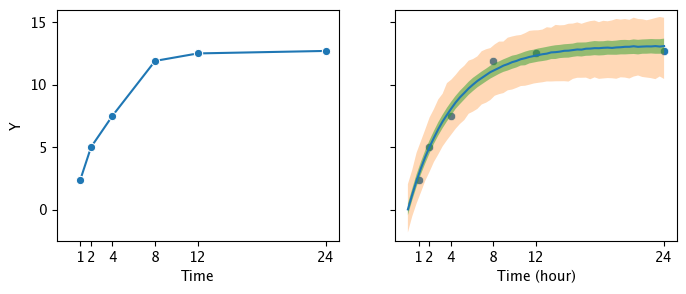

In [9]:
# グラフ描画
import seaborn as sns
from matplotlib import pyplot as plt


def calc_quantiles(y_pred: np.ndarray, prob: list[int | float]) -> pl.DataFrame:
    """入力された数値のリストから分位数を計算."""
    return pl.DataFrame(
        np.percentile(y_pred, prob, axis=0).T,
        schema=[f"p{p}" for p in prob],
    )


d_est = calc_quantiles(fit.y_new, [2.5, 25, 50, 75, 97.5])
_, axes = plt.subplots(1, 2, figsize=(8, 3), sharex=True, sharey=True)
sns.lineplot(conc, x="Time", y="Y", marker="o", ax=axes[0])
sns.scatterplot(conc, x="Time", y="Y", ax=axes[1])
axes[1].fill_between(Time_new, d_est["p2.5"], d_est["p97.5"], alpha=0.3)
axes[1].fill_between(Time_new, d_est["p25"], d_est["p75"], alpha=0.5)
axes[1].plot(Time_new, d_est["p50"])
plt.setp(
    axes[1],
    xlabel="Time (hour)",
    ylabel="Y",
    xticks=conc["Time"],
    yticks=np.arange(0, 16, 5),
    ylim=(-2.5, 16),
)
plt.show()

このように時系列データには非線形関数の応用例が多い。例えば、振り子の振動の幅(空気抵抗などの影響で指数関数で減少)など。

他のよく知られている非線形関数の例
1. $y = C_0 \exp(-bt)$ 振り子の振幅[<sup>4)</sup>](#fn4)
2. $y = C_0 / \{1 + a \exp(-bt) \}$ S字型に増加する
3. $y = C_0 \{ \exp(-b_2t) - \exp(-b_1t) \}$ ある時点から減少する[<sup>5)</sup>](#fn5)

![Alt text](chap07/output/fig7-7.png)

> [<sup id="fn4">4)</sup>](#fn4-back) この現象の背後には、常微分方程式で書くと、$dy / dt = -by$ (ただし$b > 0$)という関係があると考えられる。

> [<sup id="fn5">5)</sup>](#fn5-back) 前者は$dy/dt = -py^2 + qy$ (ただし$p, q \gt 0$で、$p, q$と$a,b,C_0$の間には関係式がある)という常微分方程式の解である。後者は以下の連立常微分方程式の解($y_2$の時間変化)である。
> $$
> \begin{cases}
>     dy_1 / dt = -b_1 y_1 \\
>     dy_2 / dt = -b_1 y_1 -b_2 y_2
> \end{cases}
> ただし(b_1 \gt b_2 \gt 0)
> $$


## 7.4 多重共線性

重回帰分析において、説明変数間の相関が非常に高いために，回帰係数が収束せずにうまく推定できないことがある。この状況を多重共線性があるといい、マルチコ(multicollinearity)とも呼ばれる。

例として相関の高い説明変数$A[n]$と$B[n]$があるとする($B[n] \cong A[n]$ ほとんど等しい)。この時のモデル式を以下とする。

$$
\mu[n] = b + b_2 A[n] + b_3 B[n] \quad n = 1, \ldots, N \\
Y[n] \sim \mathrm{Normal}(\mu[n], \sigma) \quad n = 1, \ldots, N
$$
これを近似すると以下のように変形される。
$$
\mu[n] = b + (b_2 + b_3)A[n] \quad n = 1, \ldots, N \\
Y[n] \sim \mathrm{Normal}(\mu[n], \sigma) \quad n = 1, \ldots, N
$$

このモデル式からb2とb3の値を推定する場合、一意に値が決まらず収束しない。($b_2 + b_3 = 3が真の値のとき、b_2 = 3, b_3 = 0でも、b_2 = 0, b_3 = 3でも成り立つ$)

対策としては、説明変数の背景知識から相関が明らかな場合には片方を捨てるのが簡単。例えば[7.2節](#72-対数を取るか否か)の賃貸物件のデータでは、「物件の広さ(m3)」と「部屋の数」の間の相関が高い場合には「部屋の数」を捨てるなど。

説明変数の数が多い場合、説明変数間の相関係数行列を総当りし、相関係数の絶対値がある閾値以上なら、片方の説明変数を捨てる。閾値としては 0.8～0.95ぐらいがしばしば使われるようだ。[<sup>6)</sup>](#fn6)

> [<sup id="fn6">6)</sup>](#fn6-back) 相関係数の代わりに分散拡大要因(Variance Inflation Factor, VIF)を使うこともある。この時しきい値は10がよく使われる。
> $$VIF = 1 / (1 - 相関係数^2)$$

## 7.5 交絡(confounding)

モデルに入っていない、応答変数と説明変数の両方に影響を与える変数(交絡変数)が存在すること。この交絡変数が現象の真の原因なのに、説明変数を原因とみなしてしまうという問題が発生する。

架空の小学生の50m走のデータ([data-50m.txt](chap07/input/data-50m.txt), 66人分)で、平均秒速Y(m/s)と体重Weight(kg)のグラフを書くと下記のように相関が見られるが、これは年齢Ageが説明変数から抜け落ちているのであり、それを考慮したグラフを見るとむしろ同年齢で体重が増えすぎると速さは落ちる事がわかる。

![Alt text](chap07/output/fig7-8-left.png)
![Alt text](chap07/output/fig7-8-right.png)

この結果と経験則から、
- 年齢に比例して体重が増える
- 年齢に伴い走る速さが増す(筋肉が増える)
- 体重が増えすぎると走る速さが遅くなる

これをモデル式で表すと、例えば以下のようなモデル式が立つ。

モデル式 7-5

$$
\begin{align}
\mu_{Weight}[n] &= c_1 + c_2 Age[n] \quad &n = 1, \ldots, N \nonumber \\
Weight[n] &\sim \mathrm{Normal}(\mu_{Weight}[n], \sigma_{W}) \quad &n = 1, \ldots, N \nonumber \\
\mu_{Y}[n] &= b_1 + b_2 Age[n] + b_3 Weight[n] &\quad n = 1, \ldots, N \nonumber \\
Y[n] &\sim \mathrm{Normal}(\mu_{Y}[n], \sigma_Y) \quad &n = 1, \ldots, N \nonumber 
\end{align}
$$

このモデル式を実装し回帰係数の中央値と95%ベイズ推定を取ると、

$$c_2: 3.96 (3.46 \sim 4.43) \quad b_2: 0.59 (0.50 \sim 0.68) \quad b_3: -0.03 (-0.06 \sim -0.01)$$

となり、体重への年齢の影響$c_2$と速さへの年齢の影響$b_2$が正、速さへの体重の影響$b_3$が負になっていることがわかる。このような複数の回帰を組み合わせて変数間の因果関係を調べる手法を**パス解析(path analysis)**と呼ぶ。

はじめはシンプルな仮定を優先し、新たな知見やデータ解析のサイクルから背景知識が増えたときにモデルを更新するといいだろう。

以下も参考になる
- 因果推論: 岩波データサイエンス vol3
- SEM(structural equation modeling): 原因を探る統計学

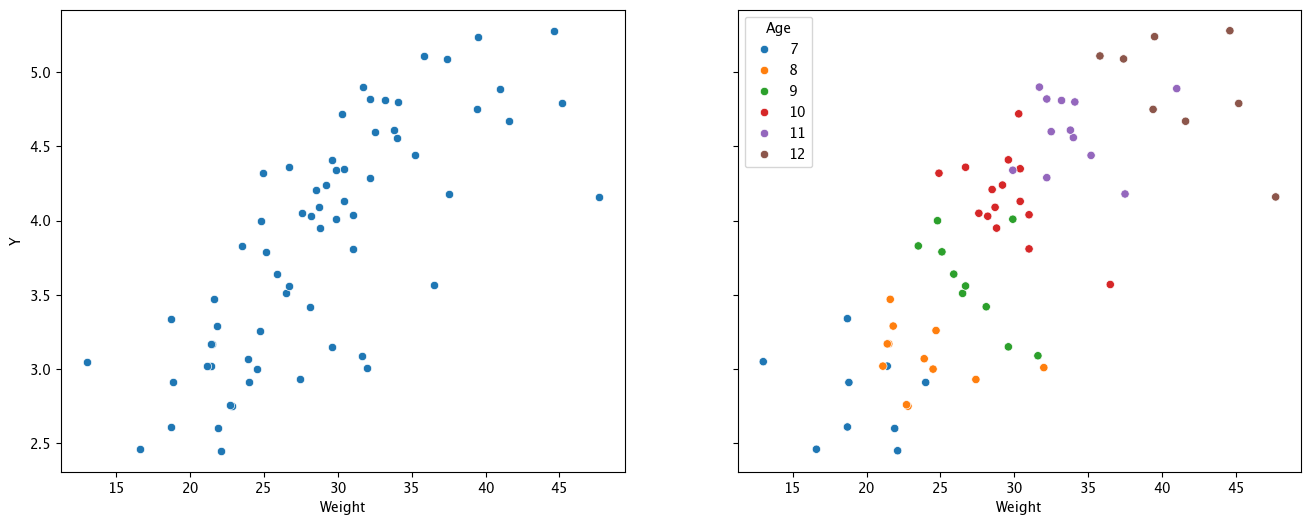

06:01:58 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

06:02:00 - cmdstanpy - INFO - CmdStan done processing.


,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
lp__,-57.27060,0.052316,1.914060,-60.946100,-56.91870,-54.786600,1338.57,525.547,0.999677
c[1],19.09090,0.015802,0.753173,17.833200,19.09400,20.351000,2271.66,891.896,1.000040
c[2],3.95282,0.005407,0.255181,3.531860,3.95599,4.379440,2227.15,874.421,1.000570
b[1],3.40365,0.005032,0.212670,3.049570,3.40876,3.758830,1786.09,701.250,0.999318
b[2],0.58899,0.001166,0.047538,0.509592,0.58984,0.665887,1663.43,653.092,0.999689
...,...,...,...,...,...,...,...,...,...
mu_Y[62],4.67800,0.002336,0.112531,4.496650,4.67630,4.861460,2320.66,911.136,1.000010
mu_Y[63],4.96869,0.000888,0.061775,4.868390,4.97025,5.069920,4836.29,1898.820,1.000570
mu_Y[64],5.03874,0.000990,0.063587,4.932240,5.03998,5.142780,4129.06,1621.140,1.000400
mu_Y[65],4.96519,0.000889,0.061878,4.864440,4.96676,5.066800,4842.06,1901.080,1.000570


In [10]:
import matplotlib.pyplot as plt
import polars as pl
import seaborn as sns
from cmdstanpy import CmdStanModel

d = pl.read_csv("chap07/input/data-50m.txt")
d = d.with_columns(pl.col("Age").cast(str).cast(pl.Categorical))
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6), sharex=True, sharey=True)
sns.scatterplot(d, x="Weight", y="Y", ax=ax1)
sns.scatterplot(d, x="Weight", y="Y", hue="Age", ax=ax2)
plt.show()

d = d.with_columns(pl.col("Age").cast(int))
data = {col: d[col].to_list() for col in d.columns}
data["N"] = d.shape[0]
sm = CmdStanModel(stan_file="chap07/model/model7-5.stan")
fit = sm.sample(data=data, seed=1234)

fit.summary()

## 7.6 説明変数が多すぎる

回帰をするときに説明変数が多すぎて、うまく推定できない場合は理想的には説明変数感の関係を含めてモデリングする。

ただし説明変数感の関係の情報がわからない場合も多いため、その時は説明変数を減らすのがよい。以下のような方法がある。

- 0/1の二値データだが、片方にデータが偏っている場合。その説明変数を削除。
- 説明変数に階層的クラスタリング(例えばRのhclust関数、pythonではscipy.cluster.hierarchy)を行い、類似性の高い説明変数をまとめる。または主要な説明変数だけを使う。
- 主成分分析などで次元を減らす。ただし解釈が難しくなる可能性あり。
- Bayesian Lasso (least absolute shrinkage and selection operator)を用いた説明変数選択。事前分布として、ラプラス分布(二重指数分布)を用いる。[参考](https://zenn.dev/yoshida0312/articles/ba57a187654bce)
  
  Lasso推定量はラプラス事前分布を導入した際のMAP推定とみなせる

## 7.7 説明変数にノイズを含む

4.2節の単回帰の例(年収Yと社員の年齢X)について考える。この時年齢が真の年齢$X_{true}$でなく、顔写真から年齢を予測するアプリの数値(標準偏差±2.5歳)とすると、以下のモデルが考えられる。

モデル式 7-5

$$
\begin{align}
X[n] &\sim \mathrm{Normal}(x_{true}[n], 2.5) \quad &n = 1, \ldots, N \nonumber \\
Y[n] &\sim \mathrm{Normal}(a + b x_{true}[n], \sigma_Y) \quad &n = 1, \ldots, N \nonumber \\
\end{align}
$$

実装例: [model7-6.stan](chap07/model/model7-6.stan)

このように説明変数にノイズを含む場合もStanは簡単に扱える。

In [11]:
import polars as pl
from cmdstanpy import CmdStanModel

d = pl.read_csv("chap04/input/data-salary.txt")

data = {
    "N": d.shape[0],
    "X": d["X"].to_list(),
    "Y": d["Y"].to_list(),
}

sm = CmdStanModel(stan_file="chap07/model/model7-6.stan")
fit = sm.sample(data, seed=1234)

fit.summary()

06:02:01 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

06:02:01 - cmdstanpy - INFO - CmdStan done processing.
06:02:01 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 478 divergent transitions (47.8%)
	Chain 2 had 28 divergent transitions (2.8%)
	Chain 3 had 10 divergent transitions (1.0%)
	Chain 4 had 7 divergent transitions (0.7%)
	Use the "diagnose()" method on the CmdStanMCMC object to see further information.


,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
lp__,-95.12620,2.505210,6.74161,-105.0660,-95.9166,-80.92650,7.24165,18.52080,1.39754
a,-121.93900,2.124220,71.66410,-245.2850,-118.5120,-7.31721,1138.16000,2910.91000,1.00544
b,22.00910,0.045787,1.57844,19.3546,22.0115,24.67330,1188.44000,3039.49000,1.00136
x_true[1],25.55390,0.048606,1.93236,22.1793,25.7574,28.58040,1580.49000,4042.18000,1.00581
x_true[2],23.85300,0.169110,1.94266,20.7302,23.7118,27.09810,131.96300,337.50100,1.02569
x_true[3],25.97970,0.145629,1.84148,23.0618,25.8325,29.05990,159.89600,408.94000,1.02297
x_true[4],31.84690,0.107851,1.76526,29.0929,31.7293,34.84460,267.89700,685.15900,1.02428
x_true[5],31.51300,0.407373,1.95211,28.6837,31.4236,34.85590,22.96280,58.72840,1.08904
x_true[6],38.15470,0.236715,2.01722,34.5554,38.4070,41.03000,72.61950,185.72800,1.03872
x_true[7],38.85710,0.033957,1.74893,35.8025,38.9161,41.69850,2652.69000,6784.38000,1.00165


## 7.8 打ち切り

データ測定に何らかの制限・限界があり、ある値以下(以上)の数値が出てこない時、このようなデータを打ち切り(Censored)ありのデータと呼ばれる。

例として、健康診断において、ある人の血中のタンパク質Yの数値(濃度)を6回測定したとする。測定機器には検出の限界(25)があるため、数値が低いと"<25"を出力する。[data-protein.txt](chap07/input/data-protein.txt)

この血中タンパク質データの平均と標準偏差を推定するとなると以下の問題がある。
- "<25"のデータを捨てる: 平均値が真の値より高くなる
- "<25"を"25"に置き換える: 数値が25で揃いやすくなり、推定される標準偏差が小さくなる

このような状況をStanで効率的に扱う。まずメカニズムを想像すると、
- 真の平均値$\mu$に測定誤差などのノイズが加わって潜在的な測定値yが生成される
- 検出限界のしきい値をLとする

モデル式7-7
$$
\begin{align}
&打ち切りがない場合 \nonumber \\
&Y[n] \sim \mathrm{Normal}(\mu, \sigma_Y) &\quad n = 1, \ldots, N_{obs} \nonumber \\
&打ち切りがある場合 \nonumber \\
&y[n] \sim \mathrm{Normal}(\mu, \sigma_Y) ただし, y[n] \lt L &\quad n = 1, \ldots, N_{cens} \nonumber \\
\end{align}
$$

添字obsはobserved, censはcensored。

次に測定の尤度を考える。
- 打ち切りがない場合: $\mathrm{Normal}(Y|\mu, \sigma_Y)$
- 打切りがある場合:   $y \lt L$となる確率 $\mathrm{Prob}[y \lt L]$

この尤度$\mathrm{Prob}[y \lt L]$を以下のように変形する。

$$
\begin{align}
\mathrm{Prob}[y \lt L] &= \int_{-\infty}^L \mathrm{Normal}(y|\mu, \sigma_Y) \nonumber \\
& = \int_{-\infty}^L \frac{1}{\sqrt{2\pi\sigma}}\exp \left[-\frac{1}{2} \left(\frac{y - \mu}{\sigma} \right)^2 \right]dy \nonumber \\
& = \int_{-\infty}^{\frac{L - \mu}{\sigma}} \frac{1}{\sqrt{2\pi}}\exp \left[-\frac{1}{2}z^2 \right]dz
= \int_{-\infty}^{\frac{L - \mu}{\sigma}} \phi(z) dz \nonumber \\
&= \Phi \left(\frac{L - \mu}{\sigma} \right)\nonumber
\end{align}
$$

ここで$\phi$は標準正規分布の確率密度関数。$\Phi$はその累積分布関数(cumulative distribution function, CDF)。なのでこの式の最後の値の対数をとり、targetに追加で足せば内部のlp__に打切りがある測定の文の対数尤度を加えることができる(4.3節参照)。

実装例: [model7-7.stan](chap07/model/model7-7.stan)

4行目: x_obsは打ち切りがない測定値である。
14〜16行目: 打ち切りがない場合とある場合を分けて対数尤度を登録している。
14～15行目: 打ち切りがない場合は単純である。
16行目：normal_lcdf(L|mu, s_x)はStanが用意している便利な関数。$log\Phi((L - \mu) / \sigma_y)$を表す。この行は以下の2行と同じ意味。


Rでの実行スクリプト: [run-model7-7.R](chap07/run-model7-7.R)

In [12]:
import polars as pl
from cmdstanpy import CmdStanModel

protein = pl.read_csv("chap07/input/data-protein.txt")

idx = protein["Y"].str.contains("<")
Y_obs = protein["Y"].filter(~idx).cast(float)
L = protein["Y"].filter(idx).str.replace("<", "").cast(float)[0]

data = {
    "N_obs": Y_obs.shape[0],
    "N_cens": idx.sum(),
    "Y_obs": Y_obs.to_list(),
    "L": L,
}
sm = CmdStanModel(stan_file="chap07/model/model7-7.stan")
fit = sm.sample(data, seed=1234)

fit.summary()

06:02:02 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

06:02:02 - cmdstanpy - INFO - CmdStan done processing.
06:02:02 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 2 had 2 divergent transitions (0.2%)
	Chain 3 had 2 divergent transitions (0.2%)
	Use the "diagnose()" method on the CmdStanMCMC object to see further information.


,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
lp__,-10.3721,0.088150,1.57044,-13.47920,-9.87432,-8.87687,317.396,4347.89,1.01061
mu,24.8341,0.890588,13.64870,6.90403,27.13750,35.37380,234.872,3217.43,1.01268
s_Y,15.9413,1.413410,23.59010,4.33062,10.03990,42.95230,278.563,3815.93,1.01112


## 7.9 外れ値

ある範囲にデータの大多数が収まるが、底から大きく外れたデータを外れ値(outlier)という。外れ値に客観的で厳密な定義はない。

統計モデリングにおける外れ値の対処法
1. 人為的なミスなどによって生じたことが明らかな場合はそのデータを除外、もしくは修正
2. 外れ値を例外と認め以降の解析から除外する
3. 稀に大きな値を生成するメカニズムを仮定して、外れ値を含めて解析を進める

2, 3についてモデリングを紹介する。

- 裾の長いコーシー分布やStudentのt分布を使う方法

  使用データ: [data-outlier.txt](chap07/input/data-outlier.txt)
    
  経験から応答変数Y、説明変数Xに比例関係があるとわかっているデータ。これについて単回帰を行う。
  
  まずは散布図を見ると、X=3の部分が外れ値のように見える。次に、ノイズの部分に正規部分を使って4.4節の単回帰と同様に回帰する。モデル式は以下
  
  モデル式7-8 (モデル式4-5の再掲)
  $$
  Y[n] \sim \mathrm{Normal}(a + bX[n], \sigma) \quad n= 1, 2, \ldots, N
  $$
  
  推定結果から予測分布を描くと下図左となり回帰直線の傾きが外れ値に引っ張られている事がわかる。
    
  次に、ノイズの背後に「たいていの場合は平均に近い値が生成されるが、まれに大きな値を生成する」メカニズムが考えられるとし、正規分布の代わりにコーシー分布を使う(6.14節参照)。モデル式にすると以下になる。
  
  モデル式 7-9
  $$
  Y[n] \sim \mathrm{Cauchy}(a + bX[n], \sigma) \quad n= 1, 2, \ldots, N
  $$

  [実装例 model7-9.stan](chap07/model/model7-9.stan)

  単回帰のコード([model4-4.stan](chap04/model/model4-4.stan))と大きく変わらない。異なる箇所は17、23行目が正規分布の代わりにコーシー分布であること。予測分布は下図右になる。

  傾きが外れ値に引っ張られていない。信頼区間幅も狭くなった。ただし正規分布とコーシー分布のどちらかが正しい訳では無い。

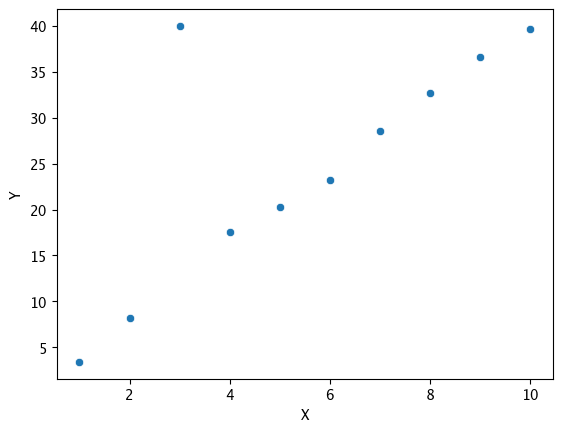

06:02:02 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

06:02:02 - cmdstanpy - INFO - CmdStan done processing.


06:02:03 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

06:02:03 - cmdstanpy - INFO - CmdStan done processing.


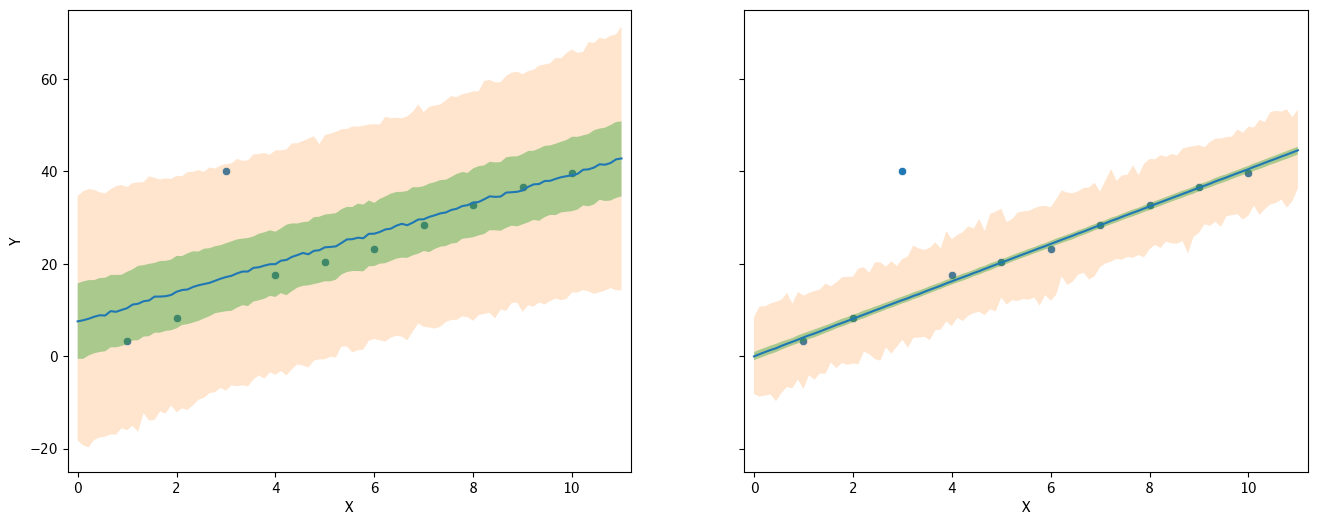

In [13]:
import matplotlib.pyplot as plt
import polars as pl
import seaborn as sns
from cmdstanpy import CmdStanModel

# 散布図
outlier = pl.read_csv("chap07/input/data-outlier.txt")
sns.scatterplot(outlier, x="X", y="Y")
plt.show()

# 以下予測分布を描画
outlier = pl.read_csv("chap07/input/data-outlier.txt")
X_new = np.linspace(0, 11, 100)
data = {
    "N": outlier.shape[0],
    "X": outlier["X"].to_list(),
    "Y": outlier["Y"].to_list(),
    "N_new": X_new.size,
    "X_new": X_new,
}

# 正規分布ノイズ(左図).
sm1 = CmdStanModel(stan_file="chap07/model/model7-8.stan")
fit1 = sm1.sample(data=data, seed=1234)
d_est1 = np.percentile(fit1.y_new, (2.5, 25, 50, 75, 97.5), axis=0)

# コーシー分布ノイズ(右図).
sm2 = CmdStanModel(stan_file="chap07/model/model7-9.stan")
fit2 = sm2.sample(data=data, seed=1234)
d_est2 = np.percentile(fit2.y_new, (2.5, 25, 50, 75, 97.5), axis=0)

_, axes = plt.subplots(1, 2, figsize=(16, 6), sharex=True, sharey=True)
for ax, d_est in zip(axes, [d_est1, d_est2], strict=True):
    sns.scatterplot(outlier, x="X", y="Y", ax=ax)
    ax.fill_between(X_new, d_est[0], d_est[-1], alpha=0.2)
    ax.fill_between(X_new, d_est[1], d_est[-2], alpha=0.4)
    ax.plot(X_new, d_est[2])
    plt.setp(ax, xlim=(-0.2, 11.2), ylim=(-25, 75))
plt.show()

- 混合正規分布や Zero-Inflated Poisson 分布などの分布を使う
  
  外れ値が多い場合(例えば全体の5%)、ヒストグラムを書くと2つの正規分布が混ざった形になる場合がある。このようなときは混合正規分布を使うという選択肢もある。

  来店回数のようなデータでは、常連客とそれ以外を混ぜた分布になる。このときには、Zero-Inflated Poisson分布(ZIP分布)を使うことができる。この分布はベルヌーイ分布とポワソン分布を混ぜたもの。

  これらの分布の詳細は11章。